In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
# Load the dataset
file_path = 'combined_df.csv'
data = pd.read_csv(file_path)

data = data[
    (data['Year'] >= 2020) &
    (data['Headliner'].str.contains('"', na=False)) &
    (~data['Support'].isna()) &
    (data['Genre'] != 'Family Entertainment')
  ]


/tmp/ipykernel_5562/4095921683.py:3: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:

# extract date features
def extract_date_features(df):
    df['Event Date'] = pd.to_datetime(df['Event Date'])
    df['Year'] = df['Event Date'].dt.year
    df['Month'] = df['Event Date'].dt.month
    df['Day of Week'] = df['Event Date'].dt.dayofweek
    return df


In [4]:

data = extract_date_features(data)

# target var and features
target = 'Avg. Gross USD'
features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
            'Market', 'Month', 'Day of Week','yt Subscriber Count','sp followers','monthly_listeners']


In [5]:

# cols_to_convert = [
#     'Avg. Gross USD', 'Avg. Tickets Sold', 'Avg. Event Capacity', 
#     'Ticket Price Min USD', 'Ticket Price Max USD', 'Ticket Price Avg. USD'
# ]
# for col in cols_to_convert:
#     data[col] = pd.to_numeric(data[col].str.replace('[^0-9.]', '', regex=True), errors='coerce')



Text(0, 0.5, 'Frequency')

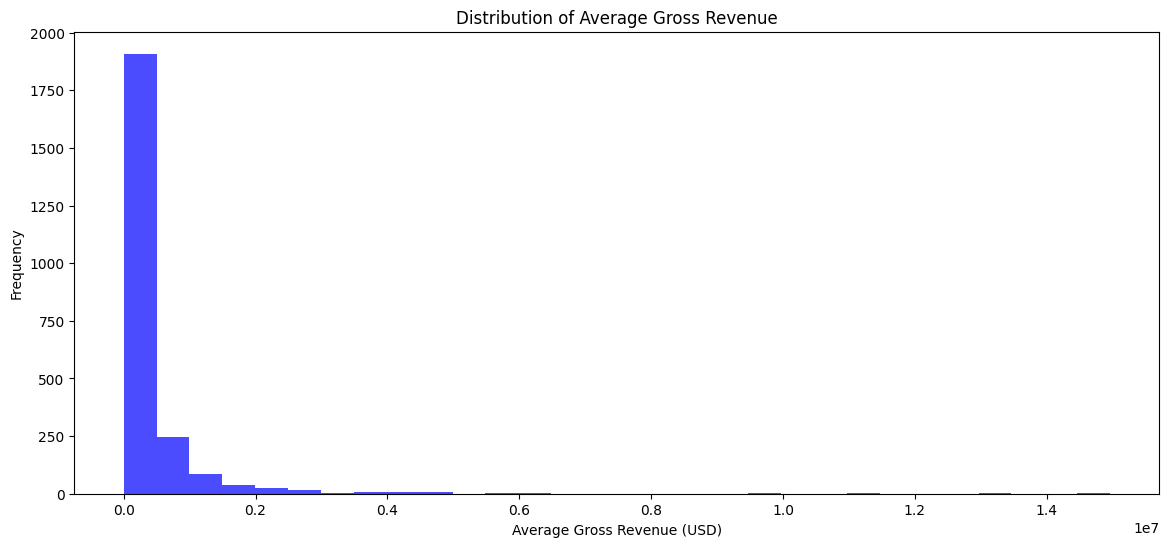

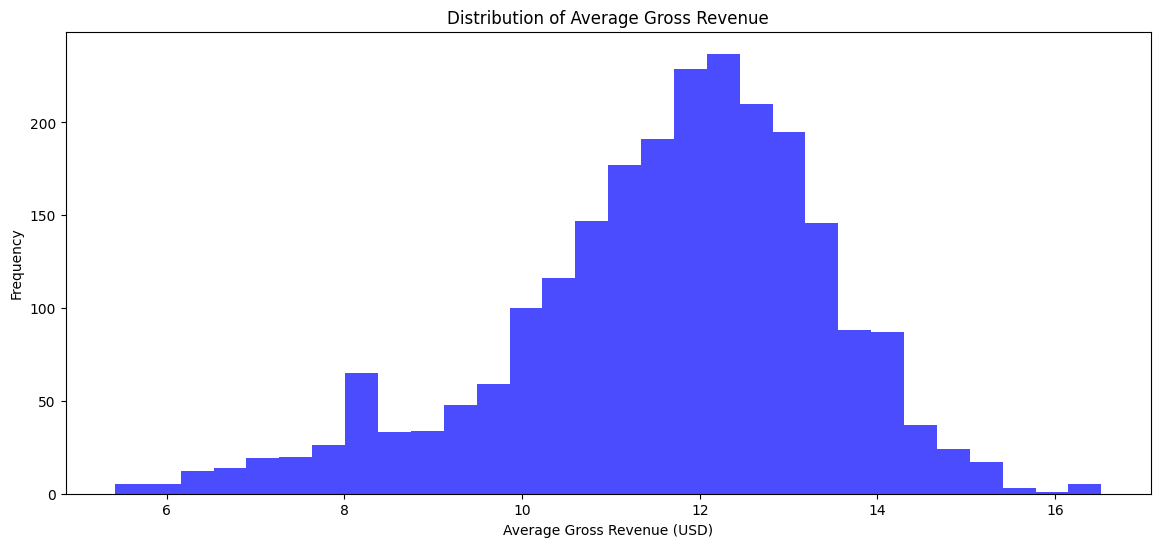

In [6]:
# Histograms for average gross revenue and log
plt.figure(figsize=(14, 6))

plt.hist(data['Avg. Gross USD'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')

plt.figure(figsize=(14, 6))

plt.hist(np.log(data['Avg. Gross USD'].dropna()), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2350 entries, 100 to 109682
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       2350 non-null   datetime64[ns]
 1   Headliner                        2350 non-null   object        
 2   sp artist_name                   92 non-null     object        
 3   sp artist_genre                  92 non-null     object        
 4   sp followers                     92 non-null     float64       
 5   sp popularity                    92 non-null     float64       
 6   yt name                          85 non-null     object        
 7   yt Channel ID                    85 non-null     object        
 8   yt Title                         85 non-null     object        
 9   yt Description                   47 non-null     object        
 10  yt Published At                  85 non-null     object      

In [8]:
# preprocessors
numerical_features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
                      'Month', 'Day of Week','yt Subscriber Count','sp followers','monthly_listeners']
categorical_features = ['Market']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Models

In [9]:
# Still working on
# Pipeline for grid search among models and features
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], data[target])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-212754.304) R2: (test=0.540) RMSE: (test=-299521.941) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-230762.466) R2: (test=0.619) RMSE: (test=-780436.738) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-267292.682) R2: (test=0.510) RMSE: (test=-521773.050) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-271876.926) R2: (test=0.618) RMSE: (test=-484890.566) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-321208.251) R2: (test=-5.551) RMSE: (test=-1859467.380) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-212754.234) R2: (test=0.540) RMSE: (test=-299591.449) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39885661718673.516, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-230603.338) R2: (test=0.619) RMSE: (test=-780339.416) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44713625196303.53, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-264611.406) R2: (test=0.512) RMSE: (test=-520547.489) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48807738449837.84, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-271876.341) R2: (test=0.618) RMSE: (test=-484890.875) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38936434814131.84, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-321261.336) R2: (test=-5.551) RMSE: (test=-1859472.691) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37452703140284.16, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-212754.034) R2: (test=0.540) RMSE: (test=-299590.616) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39885857991819.91, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-230601.650) R2: (test=0.619) RMSE: (test=-780339.929) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44713820348814.03, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-264623.722) R2: (test=0.512) RMSE: (test=-520552.616) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48807960194212.5, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-271876.034) R2: (test=0.618) RMSE: (test=-484889.917) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38936603967336.875, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-321258.137) R2: (test=-5.551) RMSE: (test=-1859470.777) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37454284080278.91, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-212752.029) R2: (test=0.540) RMSE: (test=-299582.400) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39887801227917.55, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-230584.768) R2: (test=0.619) RMSE: (test=-780345.226) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36782426614287.34, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-264729.569) R2: (test=0.512) RMSE: (test=-520596.985) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40323336981499.56, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-271872.976) R2: (test=0.618) RMSE: (test=-484880.417) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34235760894122.844, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-321227.370) R2: (test=-5.551) RMSE: (test=-1859451.376) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9787242670278.688, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-212722.510) R2: (test=0.540) RMSE: (test=-299522.444) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870928632526.4375, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-230560.021) R2: (test=0.619) RMSE: (test=-780382.330) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10905702027341.875, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=1; MAE: (test=-265342.572) R2: (test=0.512) RMSE: (test=-520866.103) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4482203090869.5625, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=1; MAE: (test=-271841.003) R2: (test=0.618) RMSE: (test=-484789.198) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=1; MAE: (test=-321109.821) R2: (test=-5.550) RMSE: (test=-1859342.187) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-107122.633) R2: (test=0.767) RMSE: (test=-213464.705) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-151507.097) R2: (test=0.793) RMSE: (test=-575631.733) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-121937.989) R2: (test=0.655) RMSE: (test=-437978.680) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-155805.975) R2: (test=0.773) RMSE: (test=-373969.321) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-84896.328) R2: (test=0.902) RMSE: (test=-227826.284) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-106073.570) R2: (test=0.766) RMSE: (test=-213856.521) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-152401.009) R2: (test=0.783) RMSE: (test=-589258.800) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-118786.146) R2: (test=0.670) RMSE: (test=-428455.909) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-148734.738) R2: (test=0.798) RMSE: (test=-352837.206) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-81707.765) R2: (test=0.907) RMSE: (test=-221302.040) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-107443.560) R2: (test=0.763) RMSE: (test=-215296.030) total time=   2.8s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-153696.542) R2: (test=0.776) RMSE: (test=-598829.028) total time=   2.8s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-119703.312) R2: (test=0.651) RMSE: (test=-440392.725) total time=   2.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-147205.566) R2: (test=0.811) RMSE: (test=-341348.448) total time=   2.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-80358.687) R2: (test=0.914) RMSE: (test=-212578.639) total time=   2.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-116775.443) R2: (test=0.734) RMSE: (test=-227949.782) total time=   0.4s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-117729.995) R2: (test=0.778) RMSE: (test=-342153.594) total time=   0.1s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-144455.252) R2: (test=0.856) RMSE: (test=-479190.558) total time=   0.0s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

In [10]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 789217.9349215165, R^2: -0.6526757497738657, MAE: 260778.92572373204
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 788968.3840688978, R^2: -0.6522471517687641, MAE: 260221.33094338403
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 788968.7709829513, R^2: -0.6522456631775808, MAE: 260222.7152457201
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 788971.2806769082, R^2: -0.6522279477303333, MAE: 260233.3426328292
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 788980.4525283994, R^2: -0.6521166648762089, MAE: 260315.18537691492
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 365774.14484189264, R^2: 0.7776918386403552, MAE: 124254.00431659576
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 361142.09516694216, R^2: 0.7846085882212208, MAE: 121540.64566944547
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 200} - RMSE: 361688.97403

In [11]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(np.exp(y_true)-1, np.exp(y_pred)-1, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(lambda y_true, y_pred:mean_absolute_error(np.exp(y_true)-1, np.exp(y_pred)-1), greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], np.log(data[target]+1))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-495946.578) R2: (test=0.461) RMSE: (test=-6379640.344) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-9683360.852) R2: (test=0.577) RMSE: (test=-114824194.317) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-18619785.169) R2: (test=0.517) RMSE: (test=-267128447.504) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-714415030.424) R2: (test=0.281) RMSE: (test=-10918451908.227) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-1139981434715253577351168.000) R2: (test=-0.958) RMSE: (test=-24714208577311568086171648.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-414708.542) R2: (test=0.466) RMSE: (test=-4606951.786) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-9488073.620) R2: (test=0.586) RMSE: (test=-111839285.648) total tim

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-231202.439) R2: (test=0.439) RMSE: (test=-695517.539) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-6668981.983) R2: (test=0.462) RMSE: (test=-81251591.557) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-26196912.320) R2: (test=0.395) RMSE: (test=-380329630.561) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1611088748.136) R2: (test=0.325) RMSE: (test=-25126086515.463) total time=   0.0s
[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-14230488781635624659582976.000) R2: (test=-1.239) RMSE: (test=-308509645154249532390768640.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-264425.980) R2: (test=0.063) RMSE: (test=-487959.118) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-427695.808) R2: (test=0.086) RMSE: (test=-1297958.533) total time=   0.0s
[CV 3/5] END model=Lasso(),

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-114127.467) R2: (test=0.906) RMSE: (test=-225313.979) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-160944.883) R2: (test=0.918) RMSE: (test=-669089.533) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-107550.512) R2: (test=0.910) RMSE: (test=-333588.736) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-129040.692) R2: (test=0.888) RMSE: (test=-292481.928) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-82749.941) R2: (test=0.932) RMSE: (test=-240381.414) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-114261.080) R2: (test=0.908) RMSE: (test=-221265.582) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-158127.063) R2: (test=0.920) RMSE: (test=-659051.460) total time=   1.4s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-106789.988) R2: (test=0.908) RMSE: (test=-339659.480) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-137523.881) R2: (test=0.879) RMSE: (test=-307198.011) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-87435.030) R2: (test=0.935) RMSE: (test=-248928.574) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-113939.345) R2: (test=0.909) RMSE: (test=-221528.997) total time=   2.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-159692.570) R2: (test=0.919) RMSE: (test=-668548.955) total time=   2.8s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-107121.848) R2: (test=0.911) RMSE: (test=-355212.022) total time=   2.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-134633.443) R2: (test=0.882) RMSE: (test=-306786.424) total time=   2.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-82571.434) R2: (test=0.936) RMSE: (test=-231719.265) total time=   2.6s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-112353.982) R2: (test=0.

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-156050.048) R2: (test=0.905) RMSE: (test=-558392.742) total time=   0.0s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-116224.618) R2: (test=0.907) RMSE: (test=-235333.737) total time=   0.0s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-158865.921) R2: (test=0.917) RMSE: (test=-665119.952) total time=   0.0s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [16]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 4.942841715462316e+24, R^2: 0.17563548124499642, MAE: 2.279962869430509e+23
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 6.190798312487457e+24, R^2: 0.17831286106826488, MAE: 2.8556023229411193e+23
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 1.6071903434809155e+26, R^2: 0.12320798979906158, MAE: 7.413416245519039e+24
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 6.1701929030849915e+25, R^2: 0.07630021219736997, MAE: 2.846097756327125e+24
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 813096.9875069906, R^2: 0.07429923554370292, MAE: 314193.9688901492
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 352171.1180016141, R^2: 0.9108726562490679, MAE: 118882.69895504016
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 355220.62139723625, R^2: 0.9099702500007674, MAE: 120827.40841719252
Params: {'model': RandomForestRegressor(), 'model__n_estimat

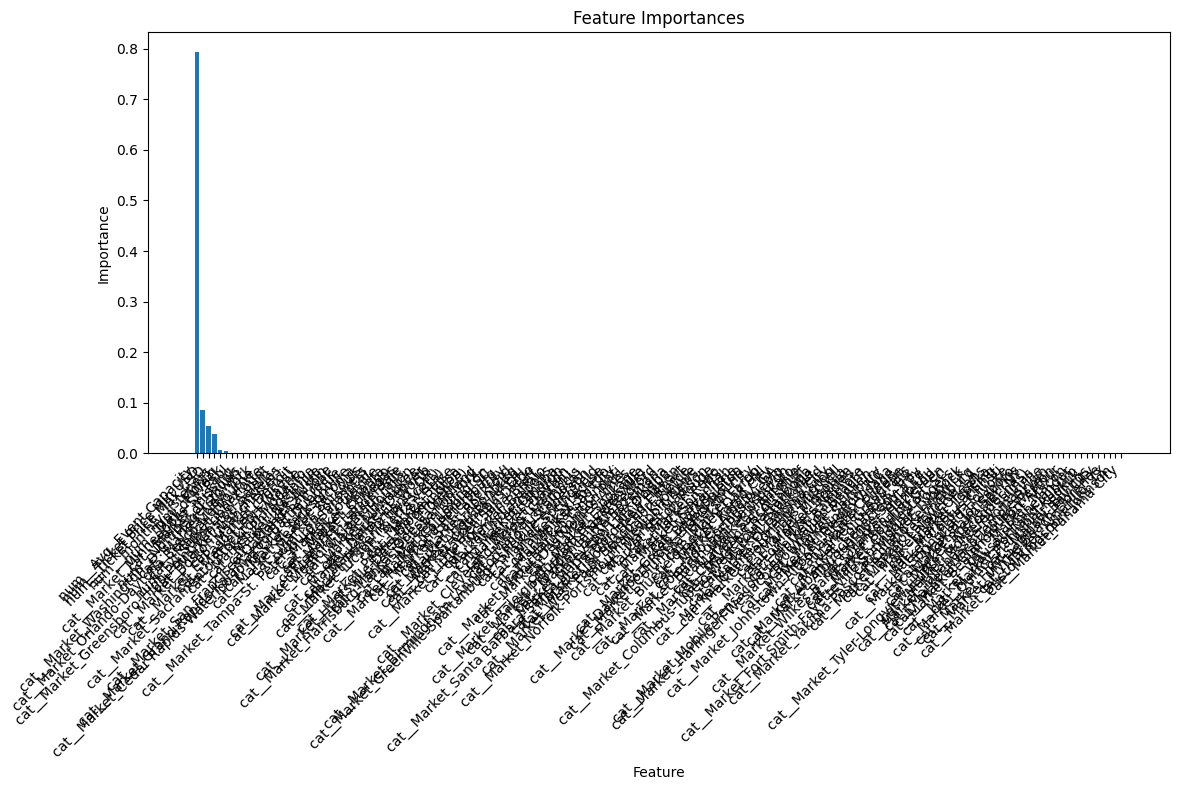

In [13]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(n_estimators=200))]) 

# Access the preprocessor and the RandomForestRegressor model
preprocessor = pipeline.named_steps['preprocessor']
random_forest = pipeline.named_steps['model']  # Correctly referencing the 'model' step

# Fit the pipeline (you must fit the pipeline before accessing feature importances)
pipeline.fit(data[features], np.log(data[target] + 1))

# Get the transformed feature names
transformed_features = preprocessor.get_feature_names_out(features)

# Get the feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': transformed_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [14]:
importance_df


,Feature,Importance
1,num__Avg. Event Capacity,7.928179e-01
2,num__Ticket Price Min USD,8.529065e-02
3,num__Ticket Price Max USD,5.469799e-02
8,num__monthly_listeners,3.780155e-02
4,num__Month,6.297281e-03
...,...,...
59,cat__Market_Flint-Saginaw-Bay City,6.751798e-07
102,cat__Market_Myrtle Beach-Florence,6.121051e-07
12,"cat__Market_Amarillo, TX",5.425095e-07
26,cat__Market_Bristol-Kingsport-Johnson,4.941516e-07


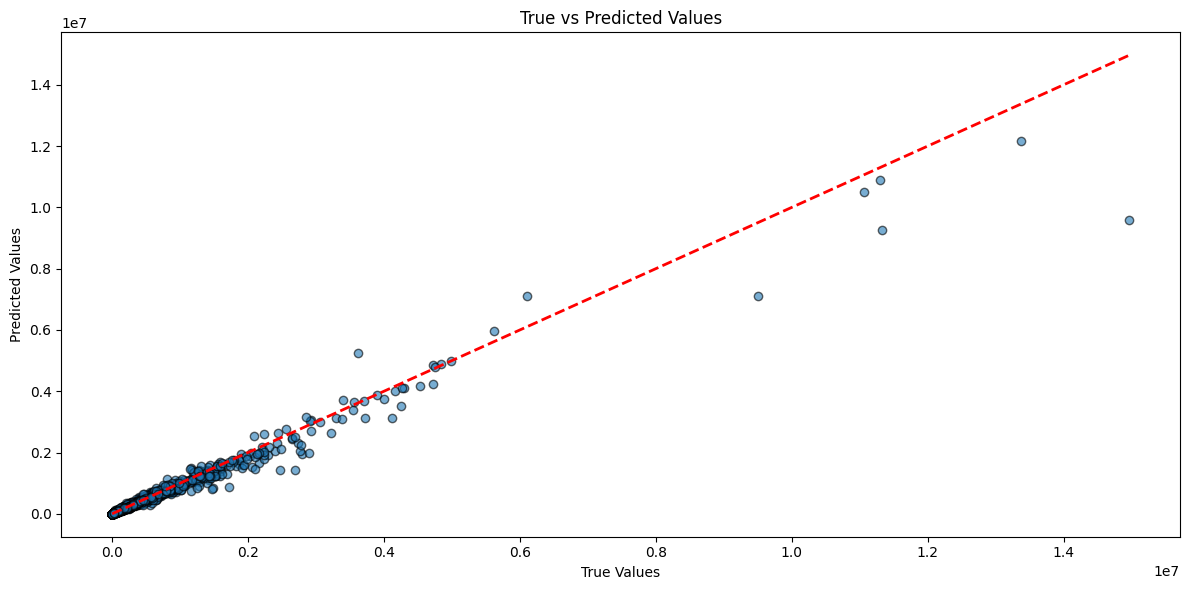

In [15]:
y_true = np.log(data[target] + 1)
y_pred = pipeline.predict(data[features])

y_true_orig = np.exp(y_true) - 1
y_pred_orig = np.exp(y_pred) - 1

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_true_orig, y_pred_orig, alpha=0.6, edgecolors='k')
plt.plot([y_true_orig.min(), y_true_orig.max()],
         [y_true_orig.min(), y_true_orig.max()], 'r--', linewidth=2)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.show()

In [18]:
data1 = data[data['City']=='Los Angeles']

In [19]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(np.exp(y_true)-1, np.exp(y_pred)-1, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(lambda y_true, y_pred:mean_absolute_error(np.exp(y_true)-1, np.exp(y_pred)-1), greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data1[features], np.log(data1[target]+1))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-436776.295) R2: (test=0.524) RMSE: (test=-535003.623) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-204039.237) R2: (test=0.448) RMSE: (test=-267310.261) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-572407729.298) R2: (test=-4.686) RMSE: (test=-1485577274.806) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-590895.732) R2: (test=0.713) RMSE: (test=-879967.372) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-6057468.678) R2: (test=-0.423) RMSE: (test=-15177143.670) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-438612.353) R2: (test=0.526) RMSE: (test=-540563.317) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-203719.343) R2: (test=0.450) RMSE: (test=-267527.009) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Subscriber Count' 'sp followers']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Subscriber Count' 'sp followers']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-389346.788) R2: (test=0.845) RMSE: (test=-563672.474) total time=   0.0s
[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-182865.934) R2: (test=0.722) RMSE: (test=-258838.867) total time=   0.0s
[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-2109252.290) R2: (test=0.507) RMSE: (test=-4622527.770) total time=   0.0s
[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-248181.362) R2: (test=0.896) RMSE: (test=-350999.173) total time=   0.0s
[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-648222.989) R2: (test=0.517) RMSE: (test=-924021.932) total time=   0.0s
[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-415739.686) R2: (test=0.842) RMSE: (test=-613379.352) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-144062.220) R2: (test=0.817) RMSE: (test=-217922.425) total time=   0.0s
[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-2061239.196) R2: (test=0.566) RMSE: (test=-4494289.294) total time=   0.0s
[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-277678.088) R2: (test=0.891) RMSE: (test=-392869.705) total time=   0.0s
[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-645941.061) R2: (test=0.540) RMSE: (test=-998251.251) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Subscriber Count' 'sp followers']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 an

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-417693.065) R2: (test=0.838) RMSE: (test=-616514.436) total time=   0.1s
[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-143156.988) R2: (test=0.845) RMSE: (test=-227934.644) total time=   0.1s
[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-2080687.916) R2: (test=0.522) RMSE: (test=-4622315.601) total time=   0.1s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Subscriber Count' 'sp followers']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['y

[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-298046.261) R2: (test=0.886) RMSE: (test=-411743.113) total time=   0.1s
[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-552003.572) R2: (test=0.620) RMSE: (test=-806706.210) total time=   0.1s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, 

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Su

[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-2028893.587) R2: (test=0.492) RMSE: (test=-4535114.538) total time=   0.0s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['yt Su

In [20]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 300487339.94639236, R^2: -0.6849395291241807, MAE: 115939381.84776954
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 294779542.7545508, R^2: -0.671791122423243, MAE: 113757068.65062456
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 248429701.52604336, R^2: -0.5592345653097166, MAE: 96026516.31948343
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 56041135.49766066, R^2: 0.021807244925479252, MAE: 22088760.917421207
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 1769547.6161224912, R^2: -0.4094158412515318, MAE: 1123244.7540796807
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 1344012.0429957896, R^2: 0.6974088099005182, MAE: 715573.8728747107
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 1343342.405234982, R^2: 0.7313625758920828, MAE: 708932.0501958183
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 200} - RMSE: 1337042.800